In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import statsmodels.api as sm

In [43]:
df = pd.read_csv('FSOData.csv')
df.shape

(91379, 11)

In [44]:
df.head()

,FSO_Att,Absolute Humidity,Wind Speed,Visibility,Time,Wind Speed Max,Temperature,Temperature Difference,Particulate,Distance,SYNOP Code
0,7.913289,17.595709,3.057066,65884.51846,9,6.863808,26.067846,13.63,0.0,2115.338398,0
1,7.451176,17.549693,2.727910,64963.41092,9,6.468903,25.645703,-0.54,0.0,2113.999257,0
2,7.072747,17.290230,1.674810,54794.28107,10,2.826916,25.653383,-0.24,0.0,2118.689047,0
3,6.949288,16.820880,0.962068,50205.64159,10,2.780643,25.646271,-0.16,0.0,2114.632339,0
4,7.361052,16.813820,1.881007,59038.32599,10,4.476298,25.673089,-0.10,0.0,2116.786055,0


In [45]:
synop_onehot = pd.get_dummies(df['SYNOP Code'], prefix='SYNOP')
df = pd.concat([df, synop_onehot], axis=1)
df = df.drop('SYNOP Code', axis=1)

time_onehot = pd.get_dummies(df['Time'], prefix='Time')
df = pd.concat([df, time_onehot], axis=1)
df = df.drop('Time', axis=1)

df.head()

,FSO_Att,Absolute Humidity,Wind Speed,Visibility,Wind Speed Max,Temperature,Temperature Difference,Particulate,Distance,SYNOP_0,...,Time_14,Time_15,Time_16,Time_17,Time_18,Time_19,Time_20,Time_21,Time_22,Time_23
0,7.913289,17.595709,3.057066,65884.51846,6.863808,26.067846,13.63,0.0,2115.338398,1,...,0,0,0,0,0,0,0,0,0,0
1,7.451176,17.549693,2.727910,64963.41092,6.468903,25.645703,-0.54,0.0,2113.999257,1,...,0,0,0,0,0,0,0,0,0,0
2,7.072747,17.290230,1.674810,54794.28107,2.826916,25.653383,-0.24,0.0,2118.689047,1,...,0,0,0,0,0,0,0,0,0,0
3,6.949288,16.820880,0.962068,50205.64159,2.780643,25.646271,-0.16,0.0,2114.632339,1,...,0,0,0,0,0,0,0,0,0,0
4,7.361052,16.813820,1.881007,59038.32599,4.476298,25.673089,-0.10,0.0,2116.786055,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df.isnull().sum()

FSO_Att                   0
Absolute Humidity         0
Wind Speed                0
Visibility                0
Wind Speed Max            0
Temperature               0
Temperature Difference    0
Particulate               0
Distance                  0
SYNOP_0                   0
SYNOP_3                   0
SYNOP_4                   0
SYNOP_5                   0
SYNOP_6                   0
SYNOP_7                   0
SYNOP_8                   0
Time_0                    0
Time_1                    0
Time_2                    0
Time_3                    0
Time_4                    0
Time_5                    0
Time_6                    0
Time_7                    0
Time_8                    0
Time_9                    0
Time_10                   0
Time_11                   0
Time_12                   0
Time_13                   0
Time_14                   0
Time_15                   0
Time_16                   0
Time_17                   0
Time_18                   0
Time_19             

In [47]:
df.duplicated().sum()

0

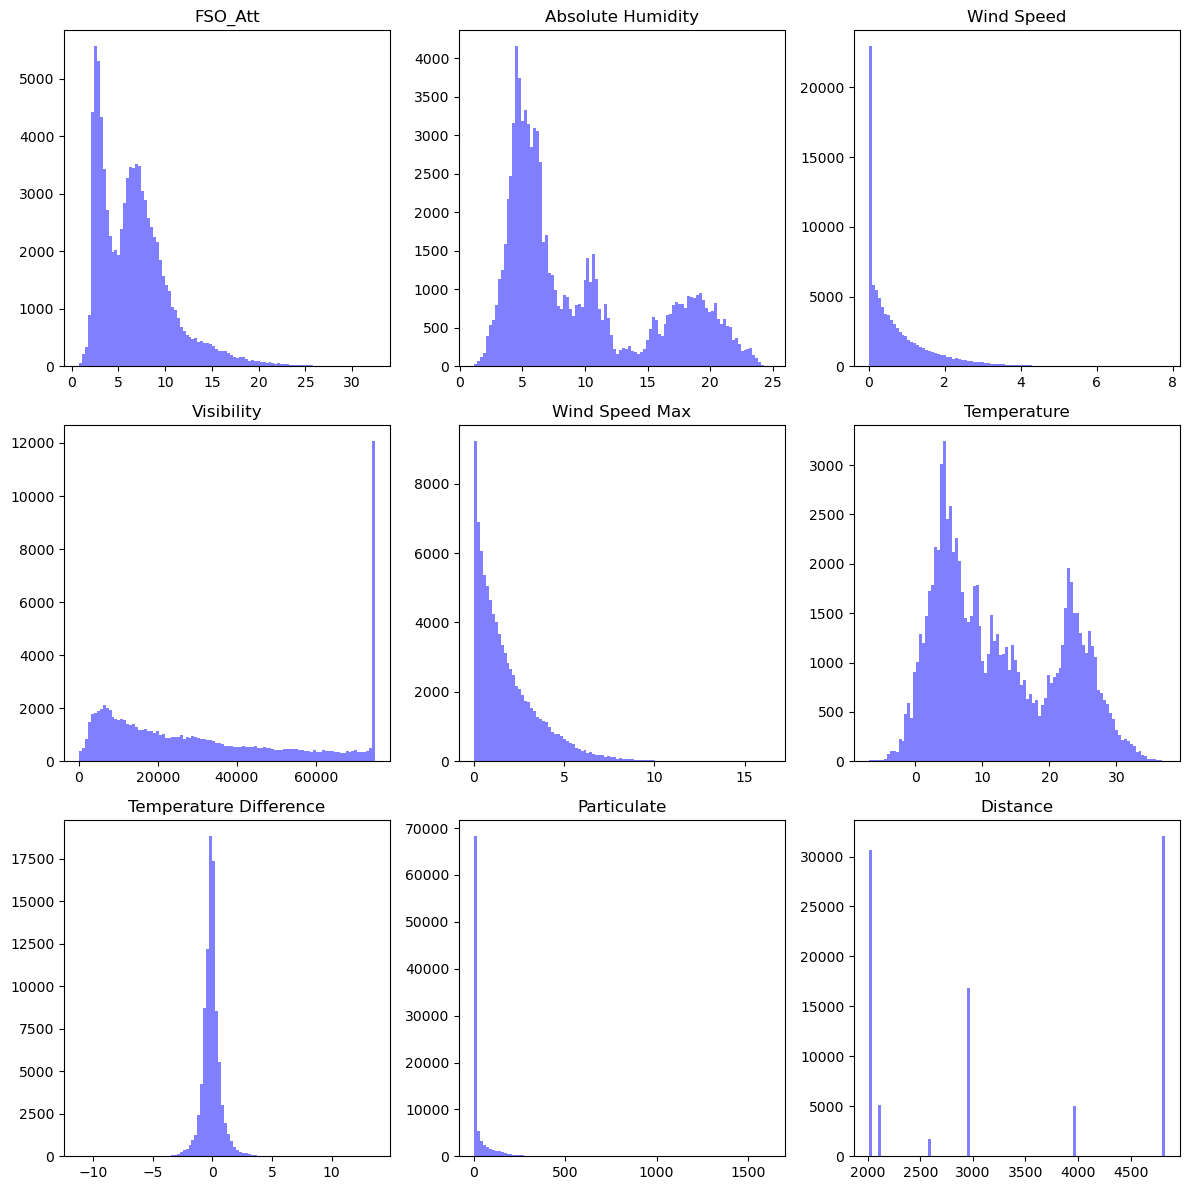

In [48]:
non_categorical_columns = [col for col in df.columns if ("SYNOP" not in col) and ("Time" not in col)]
df_non_categorical = df[non_categorical_columns]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(df_non_categorical.iloc[:, i], bins=100, alpha=0.5, color='b')
    ax.set_title(df_non_categorical.columns[i])

fig.tight_layout()

plt.show()

# Linear Regression 

In [49]:
# Initialize the LinearRegression model
regressor = LinearRegression()

# Create the linear regression pipeline
# lr_pipe = Pipeline([("standard scaler", StandardScaler()), 
#                  ("regressor", regressor)])

lr_pipe = Pipeline([("regressor", regressor)])

train_set, test_set = train_test_split(df, test_size = 0.4, random_state = 42)
# We use valid set data to compare the performance of different models

X_train = train_set.drop("FSO_Att", axis=1)
y_train = train_set["FSO_Att"]

X_test = test_set.drop("FSO_Att", axis=1)
y_test = test_set["FSO_Att"]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54827, 39) (54827,)
(36552, 39) (36552,)


In [50]:
def train_pipeline(pipeline, train_set = X_train, test_set = X_test):
    pipeline.fit(train_set, y_train)
    train_mse = mean_squared_error(y_train, pipeline.predict(train_set))
    test_mse = mean_squared_error(y_test, pipeline.predict(test_set))
    train_r2 = r2_score(y_train, pipeline.predict(train_set))
    test_r2 = r2_score(y_test, pipeline.predict(test_set))
    print("MSE train:", train_mse)
    print("MSE test:", test_mse)
    print("R2 train:", train_r2)
    print("R2 test:", test_r2)
    return {"pipeline" : pipeline, "train_mse" : train_mse, "test_mse" : test_mse, "train_r2" : train_r2, "test_r2" : test_r2, "predictos" : train_set.shape[1]}


def print_equation(model, X_train = X_train):
    print("y = ", end="")
    for i in range(len(model.coef_)):
        if model.coef_[i] != 0:
            print(f"{model.coef_[i]:.2f} * {X_train.columns[i]} + ", end="")
    print(f"{model.intercept_:.2f}")

lr_pipe = Pipeline([("regressor", LinearRegression())])
lr_pipe = train_pipeline(lr_pipe)['pipeline']
print_equation(lr_pipe['regressor'])

MSE train: 8.87980531308837
MSE test: 8.756407262911644
R2 train: 0.4196289550591724
R2 test: 0.4219390073759782
y = 0.25 * Absolute Humidity + 0.06 * Wind Speed + -0.00 * Visibility + 0.05 * Wind Speed Max + -0.05 * Temperature + 0.01 * Temperature Difference + 0.02 * Particulate + 0.00 * Distance + -0.99 * SYNOP_0 + 3.87 * SYNOP_3 + 0.20 * SYNOP_4 + -1.42 * SYNOP_5 + -1.91 * SYNOP_6 + 1.99 * SYNOP_7 + -1.74 * SYNOP_8 + -0.03 * Time_0 + 0.20 * Time_1 + 0.51 * Time_2 + 0.68 * Time_3 + 0.98 * Time_4 + 0.81 * Time_5 + 0.81 * Time_6 + 0.49 * Time_7 + 0.23 * Time_8 + -0.02 * Time_9 + -0.15 * Time_10 + -0.26 * Time_11 + -0.49 * Time_12 + -0.41 * Time_13 + -0.65 * Time_14 + -0.70 * Time_15 + -0.40 * Time_16 + -0.50 * Time_17 + -0.39 * Time_18 + -0.31 * Time_19 + -0.26 * Time_20 + -0.20 * Time_21 + 0.04 * Time_22 + 0.03 * Time_23 + 3.05


# Linear Regression with Interaction 

In [51]:
print(df.columns)

Index(['FSO_Att', 'Absolute Humidity', 'Wind Speed', 'Visibility',
       'Wind Speed Max', 'Temperature', 'Temperature Difference',
       'Particulate', 'Distance', 'SYNOP_0', 'SYNOP_3', 'SYNOP_4', 'SYNOP_5',
       'SYNOP_6', 'SYNOP_7', 'SYNOP_8', 'Time_0', 'Time_1', 'Time_2', 'Time_3',
       'Time_4', 'Time_5', 'Time_6', 'Time_7', 'Time_8', 'Time_9', 'Time_10',
       'Time_11', 'Time_12', 'Time_13', 'Time_14', 'Time_15', 'Time_16',
       'Time_17', 'Time_18', 'Time_19', 'Time_20', 'Time_21', 'Time_22',
       'Time_23'],
      dtype='object')


In [52]:
df2 = df.copy()
categorical_columns = []
for col in df2.columns:
    if ("SYNOP" in col) or ("Time" in col):
        categorical_columns.append(col)
# print(categorical_columns)

feature_columns = df2.columns.drop(categorical_columns + ['FSO_Att'])

combinaisons = list(itertools.combinations(feature_columns, 2))

for a, b in combinaisons:
    df2["{a} * {b}".format(a = a, b = b)] = df2[a] * df2[b]
    
for col in feature_columns:
    df2["{}^2".format(col)] = df2[col] ** 2

for col in feature_columns:
    for cat in categorical_columns:
        df2["{} * {}".format(col, cat)] = df2[col] * df2[cat]



/var/folders/k1/l4fpqgbn5hq_02pxbp2s7zkh0000gn/T/ipykernel_62880/2259310197.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["{} * {}".format(col, cat)] = df2[col] * df2[cat]
/var/folders/k1/l4fpqgbn5hq_02pxbp2s7zkh0000gn/T/ipykernel_62880/2259310197.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["{} * {}".format(col, cat)] = df2[col] * df2[cat]
/var/folders/k1/l4fpqgbn5hq_02pxbp2s7zkh0000gn/T/ipykernel_62880/2259310197.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [53]:
train_set, test_set = train_test_split(df2, test_size = 0.4, random_state = 42)

X_train = train_set.drop("FSO_Att", axis=1)
y_train = train_set["FSO_Att"]

X_test = test_set.drop("FSO_Att", axis=1)
y_test = test_set["FSO_Att"]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54827, 323) (54827,)
(36552, 323) (36552,)


## Interaction model baseline

In [54]:
lr_interaction_pipe = Pipeline([("regressor", LinearRegression())])
lr_interaction_pipe.fit(X_train, y_train)

train_pred = lr_interaction_pipe.predict(X_train)
test_pred = lr_interaction_pipe.predict(X_test)
print("MSE train:", mean_squared_error(y_train, train_pred))
print("MSE test:", mean_squared_error(y_test, test_pred))
print("R2 train:", r2_score(y_train, train_pred))
print("R2 test:", r2_score(y_test, test_pred))

MSE train: 4.579520456056076
MSE test: 4.530517013189884
R2 train: 0.7006892630301623
R2 test: 0.7009144180813568


## Backward select features

In [55]:
def backward_selection(X, y, threshold = 0.05):
    remain_features = list(X.columns)
    
    while True:
        X_current = sm.add_constant(X[remain_features])
        model = sm.OLS(y, X_current).fit()
        
        # calculate p-values
        pvalues = model.pvalues.drop("const")
        
        # find the feature with the largest p-value
        max_pvalue = pvalues.max()
        max_pvalue_feature = pvalues.idxmax()
        
        print("Current number of features:", len(remain_features))
        print("Largest p-value:", max_pvalue)
        print("Feature with largest p-value:", max_pvalue_feature)
        print("--------------------")
        
        # if the largest p-value is larger than the threshold, remove the feature
        if max_pvalue > threshold:
            remain_features.remove(max_pvalue_feature)
        else:
            break
    
    return remain_features

In [56]:
selected_features = backward_selection(X_train, y_train)

Current number of features: 323
Largest p-value: 0.994085490680819
Feature with largest p-value: Wind Speed * Time_9
--------------------
Current number of features: 322
Largest p-value: 0.9825817908292185
Feature with largest p-value: Wind Speed Max * Time_4
--------------------
Current number of features: 321
Largest p-value: 0.9594099032469878
Feature with largest p-value: Absolute Humidity * Time_6
--------------------
Current number of features: 320
Largest p-value: 0.9483335566828975
Feature with largest p-value: Wind Speed Max * Time_9
--------------------
Current number of features: 319
Largest p-value: 0.949225731298998
Feature with largest p-value: Wind Speed * Time_8
--------------------
Current number of features: 318
Largest p-value: 0.9148594632716215
Feature with largest p-value: Visibility * Time_11
--------------------
Current number of features: 317
Largest p-value: 0.9651395576026993
Feature with largest p-value: Visibility * Time_1
--------------------
Current numbe

In [57]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [58]:
lr_interaction_pipe = Pipeline([("regressor", LinearRegression())])
lr_interaction_pipe = train_pipeline(lr_interaction_pipe, train_set=X_train, test_set=X_test)["pipeline"]

MSE train: 4.587719183619837
MSE test: 4.533872039176592
R2 train: 0.7001534062274967
R2 test: 0.7006929334479992


## Further delete features

In [59]:
coefficients = lr_interaction_pipe["regressor"].coef_
feature_variance = np.var(X_train, axis = 0)
variance_multiplied = coefficients**2 * feature_variance
variance_multiplied

Absolute Humidity     14.161168
Wind Speed             0.075308
Visibility             0.869954
Wind Speed Max         0.048237
Temperature            1.398036
                        ...    
Distance * Time_19     0.321687
Distance * Time_20     0.278053
Distance * Time_21     0.220945
Distance * Time_22     0.375460
Distance * Time_23     0.398137
Length: 225, dtype: float64

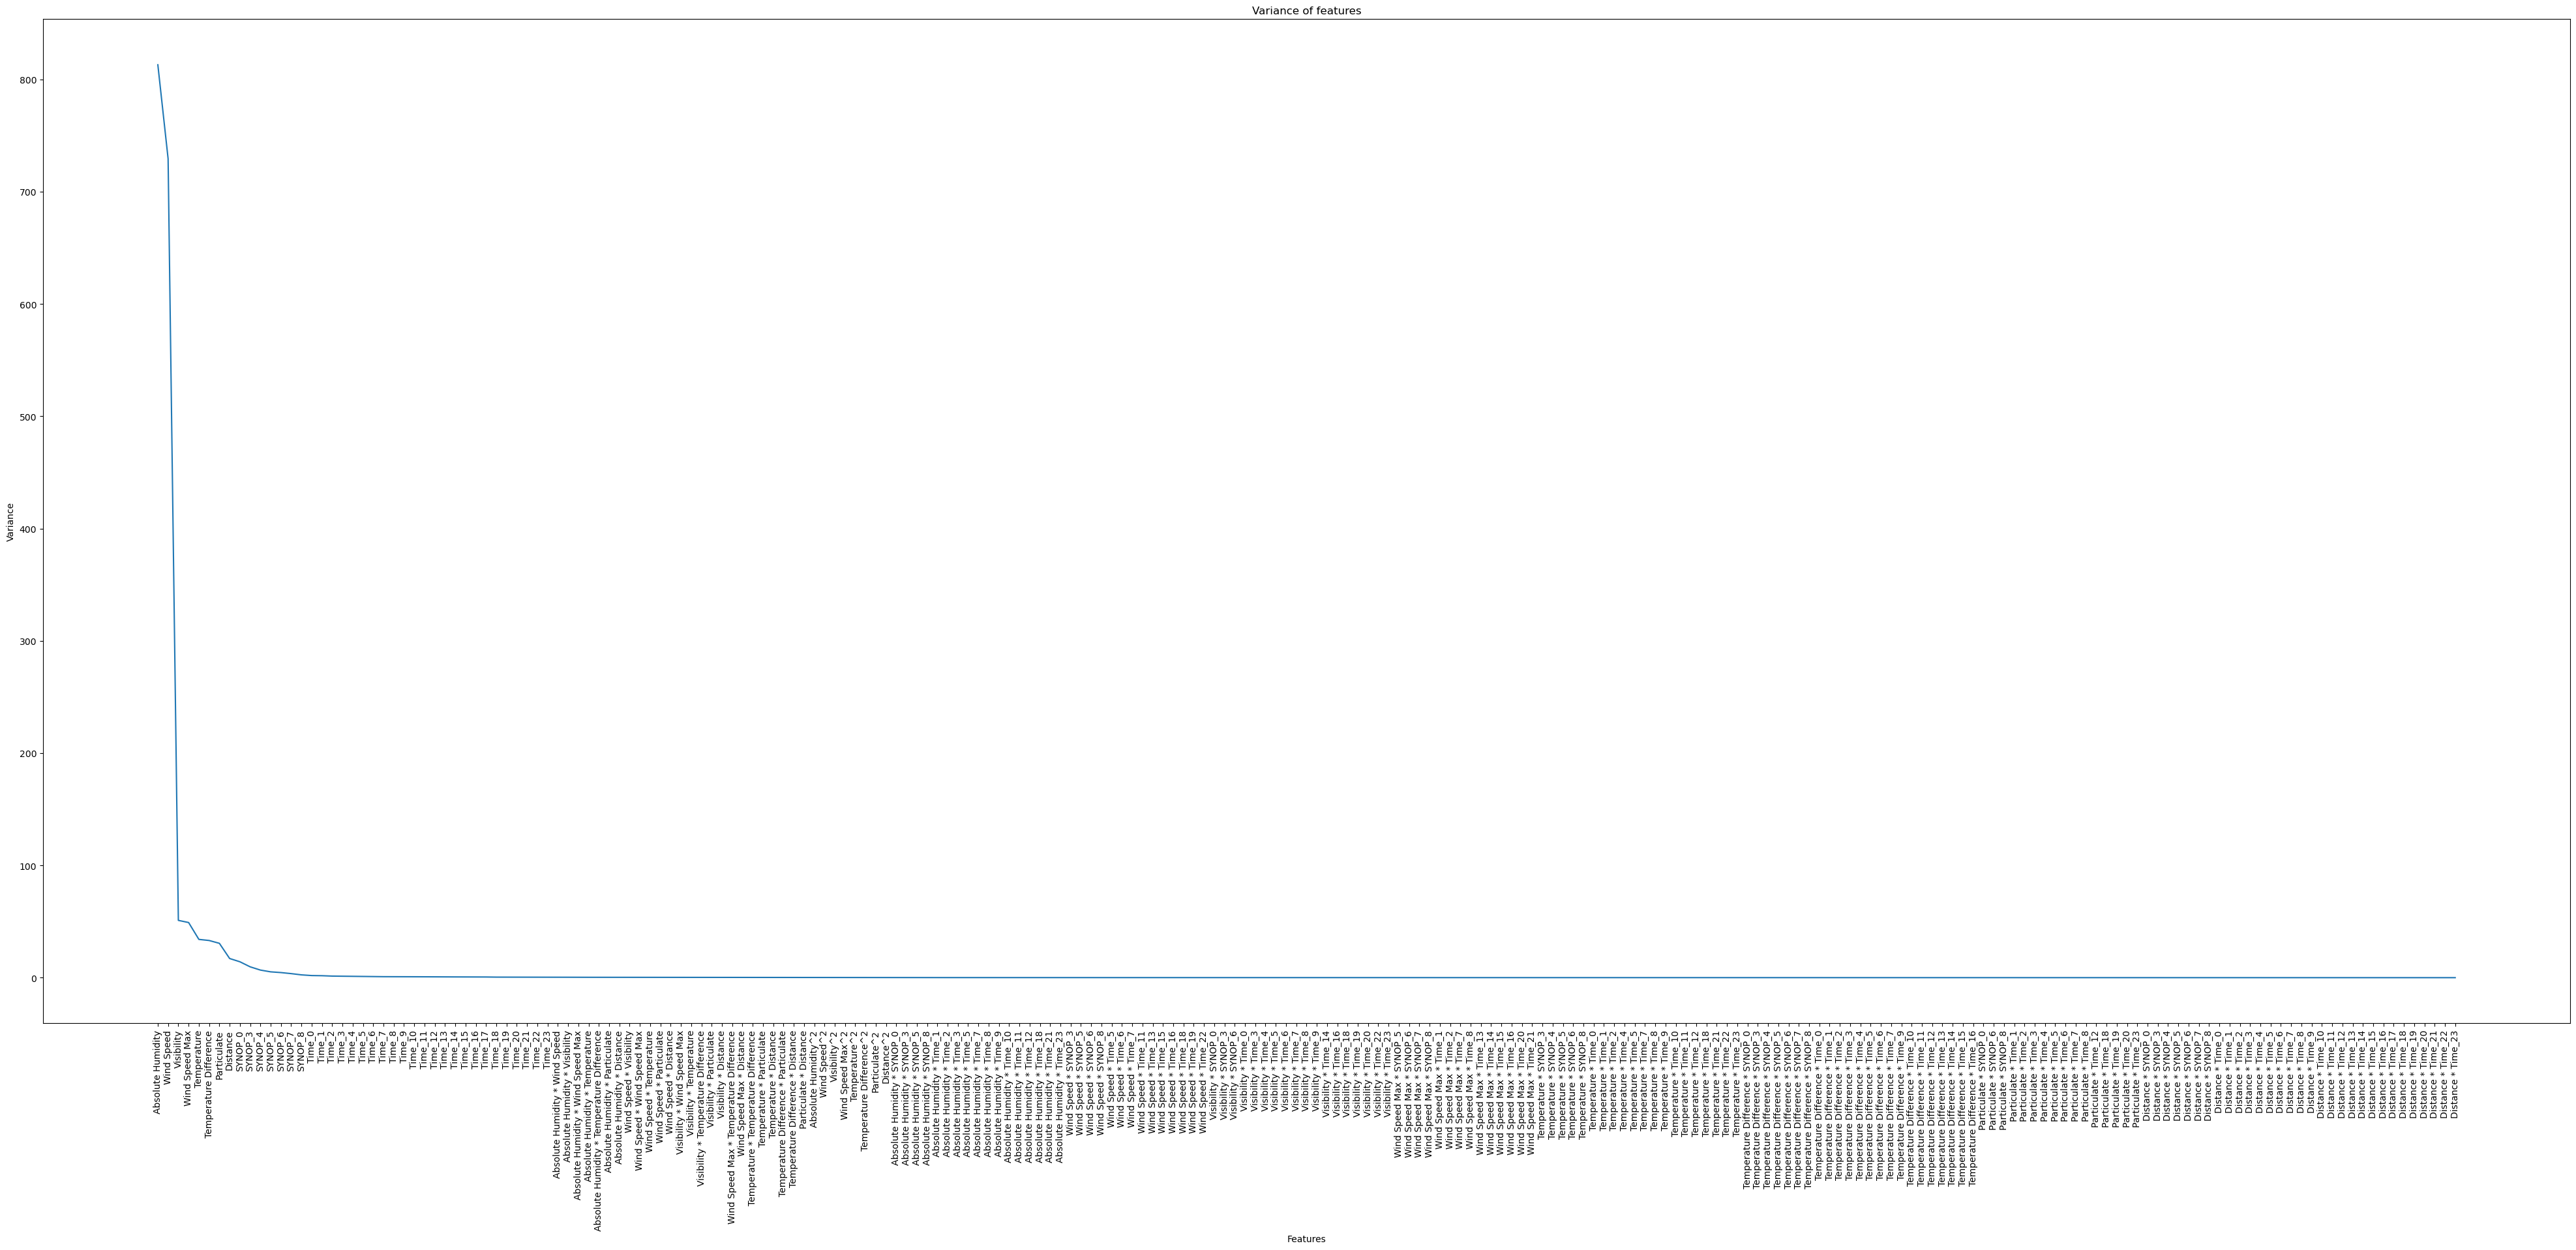

In [60]:
sorted_feature_variance = sorted(variance_multiplied, reverse = True)
plt.figure(figsize=(50, 20))
plt.plot(sorted_feature_variance)
plt.xlabel("Features")
plt.ylabel("Variance")
plt.xticks(range(len(sorted_feature_variance)), X_train.columns, rotation = 90)
# plt.yticks(sorted_feature_variance)
plt.title("Variance of features")
plt.savefig("./", dpi = 600, bbox_inches = "tight")
plt.show()

In [65]:
def feature_select_thresold(threshold):
    important_features = variance_multiplied > threshold
    important_features_indices = np.where(important_features)[0]
    print("-------------------------------------------------------------------------")
    print("Current threshold:", threshold)
    print("Current Number of features:", len(important_features_indices))
    # print("---------------------", "Trying Model with", len(important_features_indices), "features", "--------------------")
    # print(important_features_indices)
    train_set = X_train.iloc[:, important_features_indices]
    test_set = X_test.iloc[:, important_features_indices]
    
    # lr_interaction_pipe = Pipeline([("standard_scaler", StandardScaler()), 
    #                          ("regressor", LinearRegression())])
    
    lr_interaction_pipe = Pipeline([("regressor", LinearRegression())])
    
    lr_interaction_pipe.fit(train_set, y_train)
    train_mse = mean_squared_error(y_train, lr_interaction_pipe.predict(train_set))
    test_mse = mean_squared_error(y_test, lr_interaction_pipe.predict(test_set))
    train_r2 = r2_score(y_train, lr_interaction_pipe.predict(train_set))
    test_r2 = r2_score(y_test, lr_interaction_pipe.predict(test_set))

    return {"pipeline" : lr_interaction_pipe, "train_mse" : train_mse, "test_mse" : test_mse, "train_r2" : train_r2, "test_r2" : test_r2, "predictors" : len(important_features_indices)}

In [67]:
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 10, 20, 30, 40, 50]
train_mses = []
test_mses = []
train_r2s = []
test_r2s = []
n_features = []
for threshold in thresholds:
    result = feature_select_thresold(threshold)
    n_feature = result["predictors"]
    train_mse = result["train_mse"]
    test_mse = result["test_mse"]
    train_r2 = result["train_r2"]
    test_r2 = result["test_r2"]
    
    n_features.append(n_feature)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

-------------------------------------------------------------------------
Current threshold: 0.0001
Current Number of features: 223
-------------------------------------------------------------------------
Current threshold: 0.0005
Current Number of features: 219
-------------------------------------------------------------------------
Current threshold: 0.001
Current Number of features: 213
-------------------------------------------------------------------------
Current threshold: 0.005
Current Number of features: 163
-------------------------------------------------------------------------
Current threshold: 0.01
Current Number of features: 135
-------------------------------------------------------------------------
Current threshold: 0.05
Current Number of features: 84
-------------------------------------------------------------------------
Current threshold: 0.1
Current Number of features: 69
-------------------------------------------------------------------------
Current thres

In [69]:
def visulize_thresold_result(thresholds, train_result, test_result, metric):
    fig, ax = plt.subplots(figsize = (20, 8))

    ax.plot(np.arange(len(thresholds)), train_result, label = f"train_{metric}", marker = 'o')
    ax.plot(np.arange(len(thresholds)), test_result, label = f"test_{metric}", marker = 'o')
    
    xticks = np.linspace(0, len(thresholds) - 1, len(thresholds))
    ax.set_xlabel("Threshold")
    ax.set_ylabel(metric)
    ax.set_xticks(xticks)
    ax.set_xticklabels(thresholds)
    ax.set_title(f"{metric} vs Threshold")

    ax.legend()
    plt.show()

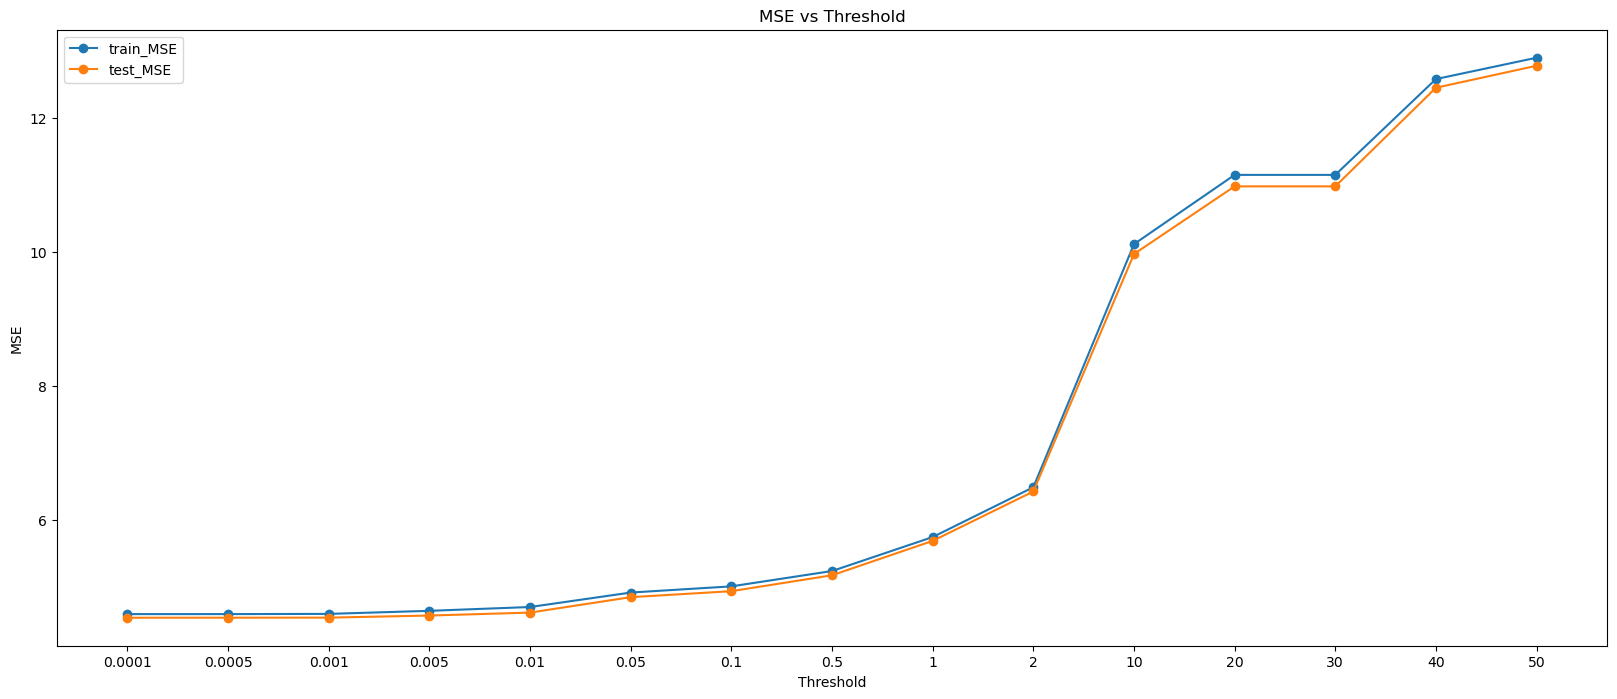

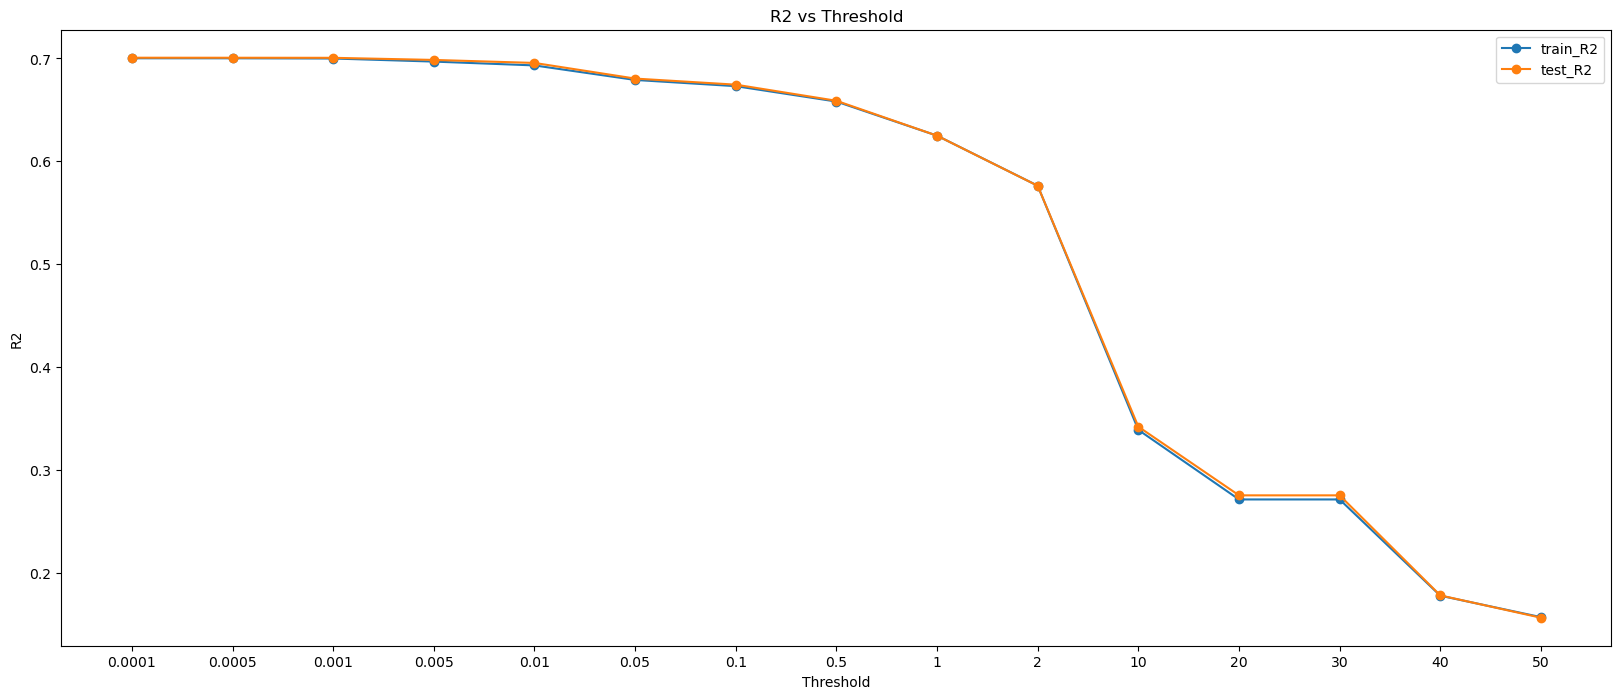

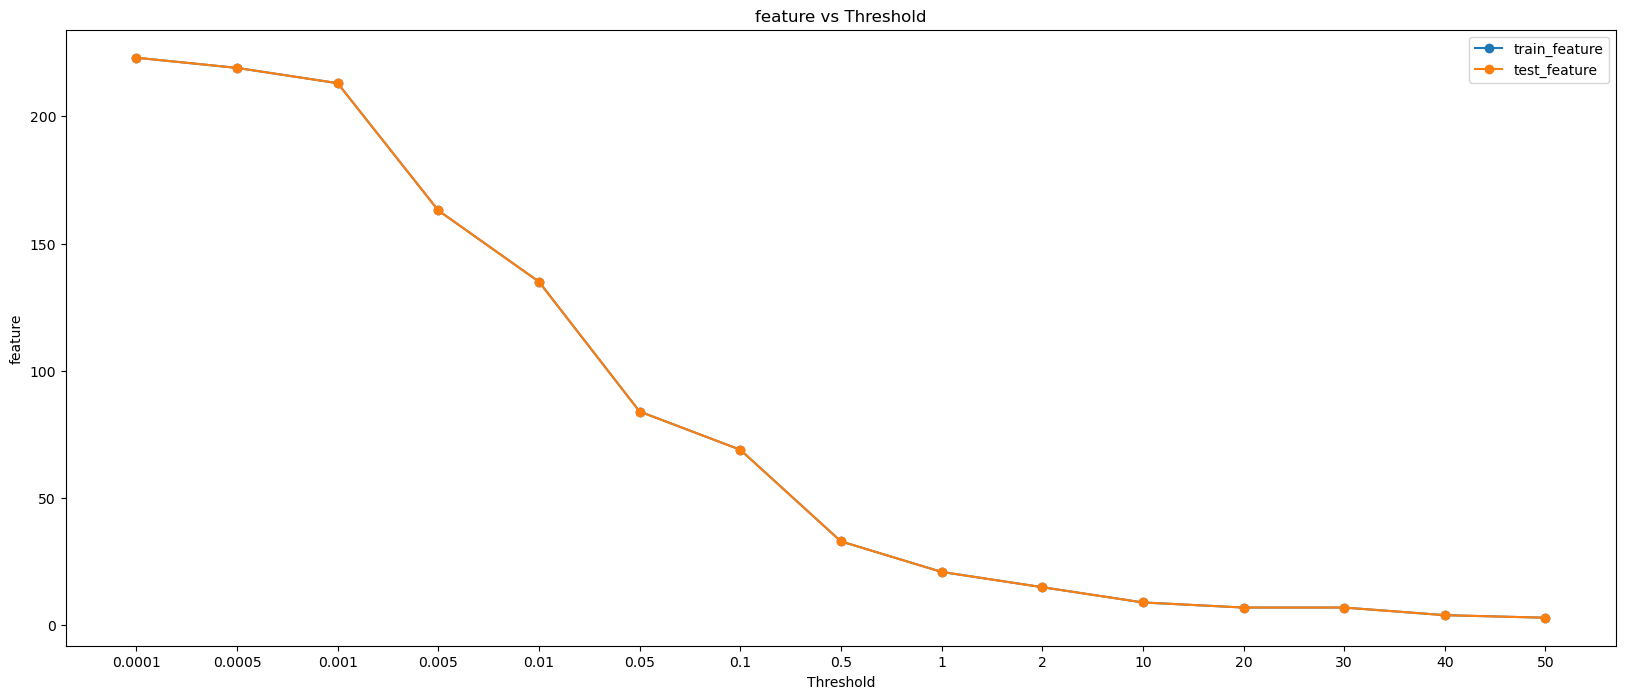

In [70]:
visulize_thresold_result(thresholds, train_mses, test_mses, "MSE")
visulize_thresold_result(thresholds, train_r2s, test_r2s, "R2")
visulize_thresold_result(thresholds, n_features, n_features, "feature")

In [72]:
result = feature_select_thresold(1)
print(result["train_mse"])
print(result["test_mse"])
print(result['train_r2'])
print(result['test_r2'])

-------------------------------------------------------------------------
Current threshold: 1
Current Number of features: 21
5.738637895072977
5.681776478960036
0.6249310481175196
0.624913134727434


In [73]:
print_equation(result['pipeline']['regressor'], X_train)

y = 0.99 * Absolute Humidity + -0.22 * Wind Speed + 0.03 * Visibility + -1.97 * Wind Speed Max + 0.06 * Temperature + -0.03 * Temperature Difference + 0.01 * Particulate + -0.00 * Distance + -0.00 * SYNOP_0 + -0.00 * SYNOP_3 + -0.01 * SYNOP_4 + -0.00 * SYNOP_5 + 0.01 * SYNOP_6 + 0.00 * SYNOP_7 + 0.03 * SYNOP_8 + -0.00 * Time_0 + -0.00 * Time_1 + -0.00 * Time_2 + -0.00 * Time_3 + 0.00 * Time_4 + -0.00 * Time_5 + -33.65
